In [1]:
#Load MNIST dataset from sklearn
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mnist['data'], mnist['target'])

In [35]:
from sklearn.decomposition import PCA
import numpy as np

def calculateOptimalDimensions(X):
    pca = PCA()
    pca.fit(X_train)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >=0.95) + 1
    print("Right number of dimensions for PCA: " + str(d))
    return d

In [39]:
dimensions = calculateOptimalDimensions(X_train)
pca = PCA(n_components=dimensions)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Right number of dimensions for PCA: 154


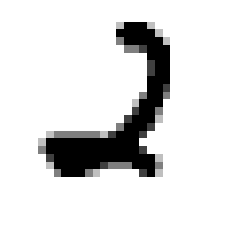

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def getDigitArray(X):
    if isinstance(X, pd.DataFrame):
        return X.to_numpy()
    else: 
        return X

def plotNumberAt(index, X):
    some_digit = getDigitArray(X)[index]
    some_digit_image = some_digit.reshape(28, 28)

    plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
    
plotNumberAt(2, X_train)

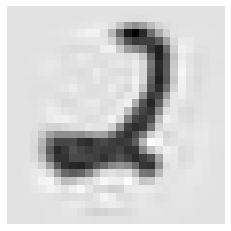

In [38]:
plotNumberAt(2, X_recovered)

In [40]:
#Same but using incremental PCA with batches of 100 samples each
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=dimensions)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Kernel PCA for the Swiss roll dataset

In [41]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets


sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0)

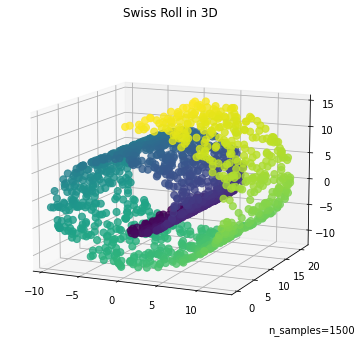

In [43]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in 3D")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

In [47]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca_gamma": np.linspace(0.03, 0.05, 10),
    "kpca_kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
# need to define y here, just an example where you can combine KPCA (unsupervised) as a previous step for a regression supervised problem
#grid_search.fit(sr_points, y)

In [49]:
#To make it enterly unsupervised, the kernel and hyperparameters can be selected to get the lowest reconstruction error

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(sr_points)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [51]:
from sklearn.metrics import mean_squared_error
mean_squared_error(sr_points, X_preimage)

# Now Grid search can be used with cross-validation to find the kernel and hyperparameters that minimize this error

31.32584454435216

LLE - Locally Linear Embedding: Manifold Learning technique

In [53]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(sr_points)

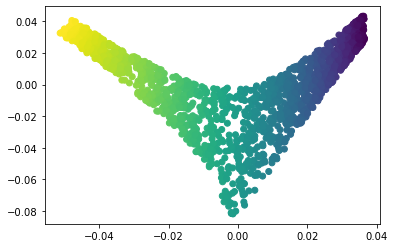

In [61]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=sr_color)